# **Visualise Class Imbalance**

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


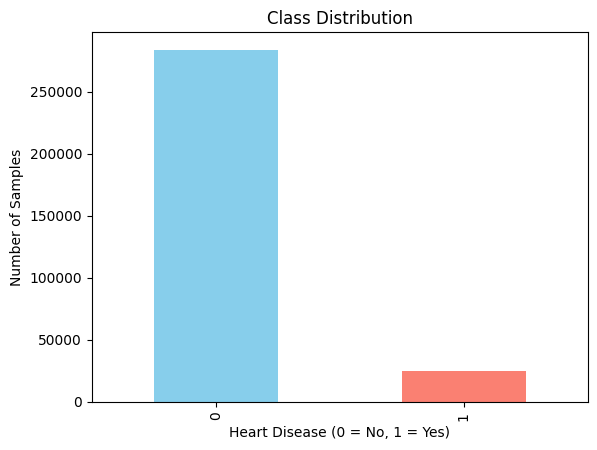

In [24]:
# Load the dataset
df = pd.read_csv('CVD_cleaned.csv')

# Encode all categorical features using LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Check the class distribution of Heart_Disease
class_counts = df['Heart_Disease'].value_counts()
print(class_counts)

# Visualise the class imbalance of Heart_Disease
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of Samples')
plt.show()

#**Build, Train & Test your XGBoost Model**

In [25]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score

In [26]:
# Define features (X) and target (y)
X = df.drop(columns='Heart_Disease')
y = df['Heart_Disease']

# Split the data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost Classifier without class weighting
xgb = XGBClassifier(n_estimators=100, max_depth=6, eta=0.3)
xgb.fit(X_train, y_train)

# Predict probabilities and class labels
y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

# Calculate loss and accuracy
loss = log_loss(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.2245
Test Accuracy: 0.9182


In [27]:
# Class weighting to help with class imbalance
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train an XGBoost Classifier with class weighting
xgb_w = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, max_depth=6, eta=0.3)
xgb_w.fit(X_train, y_train)

# Predict probabilities and class labels
y_proba_w = xgb_w.predict_proba(X_test)
y_pred_w = xgb_w.predict(X_test)

# Calculate loss and accuracy
loss_w = log_loss(y_test, y_proba_w)
accuracy_w = accuracy_score(y_test, y_pred_w)

# Print results
print(f'Test Loss: {loss_w:.4f}')
print(f'Test Accuracy: {accuracy_w:.4f}')

Test Loss: 0.4739
Test Accuracy: 0.7444


#**Plot Metrics**

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

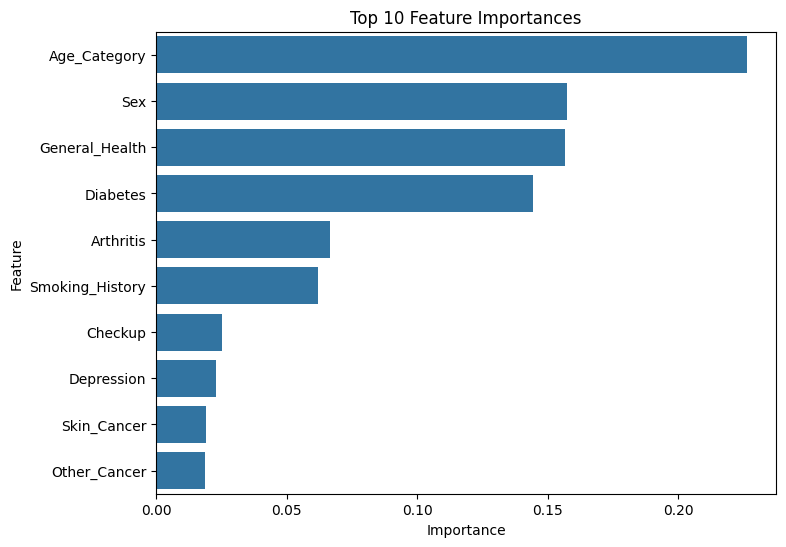

In [29]:
# Feature Importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()

In [30]:
# Compute precision, recall and F1-score of model without class weighting
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Compute precision, recall and F1-score of model with class weighting
precision_w = precision_score(y_test, y_pred_w)
recall_w = recall_score(y_test, y_pred_w)
f1_w = f1_score(y_test, y_pred_w)

# Print precision, recall and F1-score of both models
print('{:<25} {:>10} {:>10} {:>10}'.format('Model', 'Precision', 'Recall', 'F1-Score'))
print('-' * 60)
print('{:<25} {:>10.4f} {:>10.4f} {:>10.4f}'.format('Without Class Weighting', precision, recall, f1))
print('{:<25} {:>10.4f} {:>10.4f} {:>10.4f}'.format('With Class Weighting', precision_w, recall_w, f1_w))


Model                      Precision     Recall   F1-Score
------------------------------------------------------------
Without Class Weighting       0.4539     0.0532     0.0953
With Class Weighting          0.2073     0.7647     0.3262


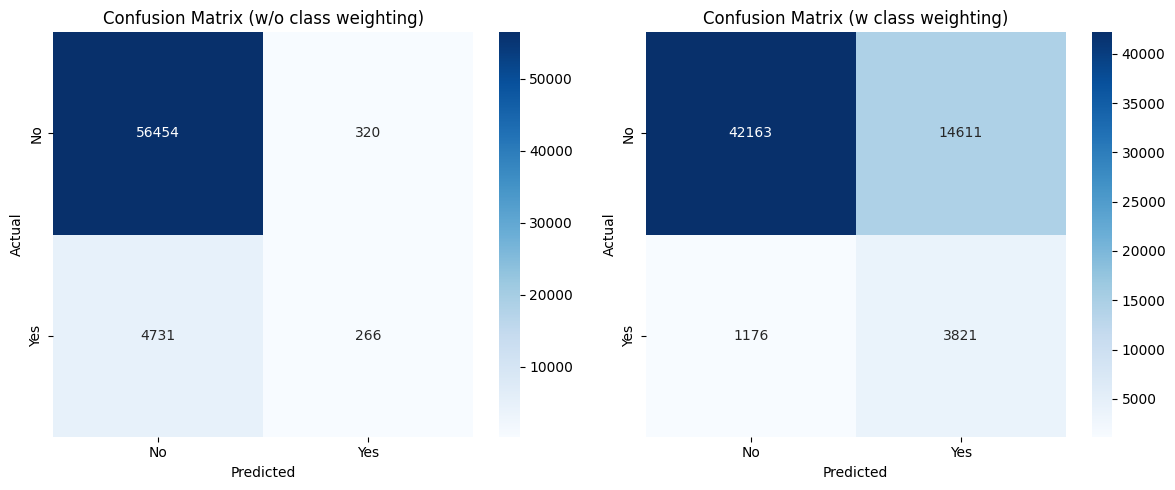

In [31]:
# Confusion Matrix for model without class weighting
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix for model with class weighting
cm_w = confusion_matrix(y_test, y_pred_w)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axes[0])
axes[0].set_title('Confusion Matrix (w/o class weighting)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the second Confusion Matrix
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axes[1])
axes[1].set_title('Confusion Matrix (w class weighting)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

#**Apply the Model**

In [32]:
# Make predictions on the test set
y_pred = xgb_w.predict(X_test)

# Get the original patient IDs (row indices in the original dataset)
patient_ids = X_test.index

# Combine and sort by patient ID
predictions = sorted(zip(patient_ids, y_pred))

# Print predictions sorted by actual patient ID
for patient_id, pred in predictions[:1000]:
    status = 'has heart disease' if pred == 1 else 'does not have heart disease'
    print(f'Patient {patient_id} {status}')

Patient 0 does not have heart disease
Patient 2 does not have heart disease
Patient 6 has heart disease
Patient 12 does not have heart disease
Patient 16 has heart disease
Patient 22 does not have heart disease
Patient 24 has heart disease
Patient 26 has heart disease
Patient 30 does not have heart disease
Patient 33 has heart disease
Patient 41 has heart disease
Patient 44 does not have heart disease
Patient 49 has heart disease
Patient 53 has heart disease
Patient 79 has heart disease
Patient 85 has heart disease
Patient 87 has heart disease
Patient 88 has heart disease
Patient 89 does not have heart disease
Patient 96 has heart disease
Patient 106 has heart disease
Patient 110 has heart disease
Patient 117 does not have heart disease
Patient 118 does not have heart disease
Patient 119 has heart disease
Patient 120 has heart disease
Patient 123 has heart disease
Patient 128 does not have heart disease
Patient 131 has heart disease
Patient 139 has heart disease
Patient 142 has heart d